In [1]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import operator



In [2]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
#model = hub.load(module_url)
model = hub.load("/Users/karinafeng/Downloads/universal-sentence-encoder_4")
#print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

In [3]:
import plotly.graph_objs as go
import plotly
import glob
import math
import statistics
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random

from sklearn.decomposition import PCA #for cluster analysis
from gensim.models import KeyedVectors #for word embeddings
import matplotlib.pyplot as plt #for plotting
import os #for importing
import pickle #for loading transcripts
from scipy.stats import pearsonr 
import nltk
from nltk import tokenize
from statistics import mean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering




# from _DRAFT_20200604_functions import * #includes constants and score function
from tqdm import tqdm_notebook #for progress bar

%autosave 5

Autosaving every 5 seconds


## Import Text Data 

#### Data is from the Dynamic Perception and Memory Lab at Columbia University

In [5]:
# importing schema texts to form script templates
directory = 'template_texts'

filenames = glob.glob(directory + '/*.txt')

dfs = {}
    
for filename in filenames:
    text1 = filename.split("/")[1]
    text2 = int(text1.split(".")[0])
    dfs[text2] = open(filename).read()
    

In [6]:
# importing participant data and summary of data

filename = 'usable_data_recall2_updated050222'
filename_sums = 'sums_usable_data_recall2'
data_dict = pickle.load( open( filename, "rb" ) )
sums = pickle.load( open( filename_sums, "rb" ) )
len(data_dict)

376

In [40]:
# import actual story texts
files1 = glob.glob('story_texts_ns/*')
len(files1)
#for filenam in files1: 
 #   print(filenam)
    
files = {}
for filenam in files1: 
    with open(filenam, "r") as file: 
        if filenam in files: 
            continue 
        else:
            x = filenam.split('ns/')[1]
            files[x] = file.read() 

In [8]:
# MAKING STORY RECALL VECTORS

### A. Organize free recalls in dict
#### dict[story]{0: [np recalls]; 1: [l recalls]; 2: [s recalls]}

recalls = {}

#get the key and prolific id 

for key in data_dict:
    # Making a column with prolific id in first row and recall in second
    this_partc = np.zeros((1,3), dtype=object)
    this_partc[0] = data_dict[key]['recall'][0]
    this_partc[0,1] = key
    this_partc[0,2] = data_dict[key]['prolific_id'][0]
    
    # Naming this story
    this_story = data_dict[key]['story'][0]
    # Naming this perspective
    this_persp = data_dict[key]['p_type'][0]
    if isinstance(this_partc[0][0], float):
        print(key, '\nthis story:', this_story, "this_persp: ", this_persp)
        pass
    else:
        if this_story in recalls:
            if this_persp in recalls[this_story]:
                recalls[this_story][this_persp] = np.vstack((recalls[this_story][this_persp],this_partc))
            else:
                recalls[this_story][this_persp] = this_partc
        else:
            recalls[this_story] = {this_persp: this_partc}

In [9]:
story_items = files.items()
story_list = list(story_items)

original_stories = pd.DataFrame(story_list)

original_stories = original_stories.rename({0: 'story_id', 1: 'story_text'}, axis=1)  # new method



In [10]:
temp = []

for s_id in recalls:
    primes = recalls.get(s_id)
    for prime_id in primes:
        arr = primes.get(prime_id)
        for i in range(arr.shape[0]):
            temp.append({
                "p_id": arr[i, 2],
                "file_loc": arr[i, 1],
                "recall": arr[i, 0],
                "story_id": s_id,
                "prime_id": prime_id
            })

In [11]:
long_df = pd.DataFrame(temp) 

In [12]:
embeddings = np.zeros(shape=(376,512)) # np arr

sentences_list = list(long_df.recall)
for x in range(376): # fill w embeddings
    embeddings[x] = embed([temp[x]["recall"]])

## Cosine Similarity

In [13]:
# get cosine similairty matrix
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity

# get topN similar sentences
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]




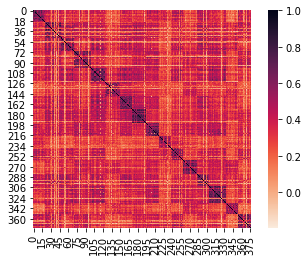

In [14]:
similarity_matrix = cos_sim(embeddings) #recalls

sns.heatmap(similarity_matrix, cmap = sns.cm.rocket_r, square = True)
plt.show() 

In [15]:
long_df.story_id.unique()

array([44, 11, 21, 12, 23, 33, 43, 13, 42, 34, 24, 32, 41, 22, 31, 14])

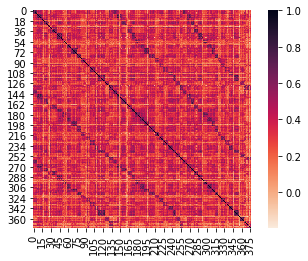

In [16]:
by_prime_l = sorted(temp, key = operator.itemgetter('prime_id'))
by_prime = pd.DataFrame(by_prime_l)

p_embeddings = np.zeros(shape=(376,512)) # np arr
p_sentences_list = list(by_prime.recall)

for x in range(376): # fill w embeddings
    p_embeddings[x] = embed([by_prime_l[x]["recall"]])

p_similarity_matrix = cos_sim(p_embeddings) #recalls

sns.heatmap(p_similarity_matrix, cmap = sns.cm.rocket_r, square = True)
plt.show() 

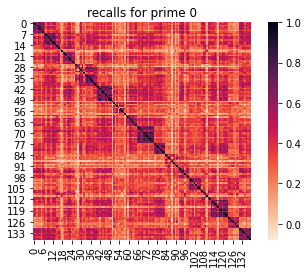

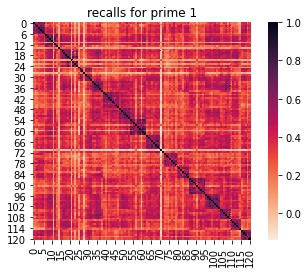

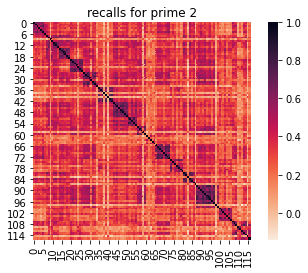

In [17]:
for i in range(3):
    p_name = i

    p_min = min(by_prime[by_prime.prime_id == p_name].index.values)
    p_max = max(by_prime[by_prime.prime_id == p_name].index.values)+1
    ax = plt.axes()

    sns.heatmap(p_similarity_matrix[p_min:p_max, p_min:p_max], cmap = sns.cm.rocket_r, ax = ax, square = True)
    ax.set_title(" ".join(['recalls for prime', str(p_name)]))
    plt.show() # comparing recalls with recalls, by priming group
  

## Random Forest

#### The same code was used to model the classification of stories and priming groups. This currently shows the priming group model. To see the stories, replace "p_labels" with "labels." Additionally, this code only displays one iteration of the model. There were several models, untuned and tuned, that can be displayed by changing the hyperparameters in the model. 

In [20]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn import metrics



In [18]:
labels = np.array(long_df["story_id"])
feature_list = list(range(513))
p_labels = np.array(long_df["prime_id"])


perm = embeddings[:,0]
random.shuffle(perm)
rand = np.append(embeddings, perm[:,None], 1)


In [21]:
# Split the data into training and testing sets

# replace p_labels with labels to see stories
train_features, test_features, train_labels, test_labels = train_test_split(rand, p_labels, test_size = 0.40, random_state = 42)

In [22]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(max_depth=50, max_features=12, random_state = 42, oob_score = True)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_features,train_labels)

test_pred=clf.predict(test_features)

In [23]:
param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[10, 50, 100],
    "max_features":[6,8,10,12,14,16]
}

rf_reg = RandomForestClassifier()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(train_features,train_labels)
rf_reg_tuned.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


RandomForestClassifier(max_depth=100, max_features=14)

In [24]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, test_pred))

# 0.9072847682119205
# 0.8874172185430463 with rand, no tuning

# 0.3443708609271523 for predicting priming 

# Accuracy: 0.9072847682119205 with tuning
# RandomForestClassifier(max_depth=10, max_features=12, n_estimators=300)

Accuracy: 0.33112582781456956


In [25]:
from numpy import std
from sklearn.model_selection import RepeatedStratifiedKFold
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
n_scores = cross_val_score(clf, embeddings, p_labels, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy of model with CV: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# model achieved an estimated classification accuracy of about 0.934 for rand
# Accuracy of model with CV: 0.941 (0.036) for tuned RF
# Accuracy of model with CV: 0.333 (0.074) for priming

Accuracy of model with CV: 0.333 (0.082)


In [26]:
rfc_cv_score = cross_val_score(clf, embeddings, p_labels, cv=10, scoring="neg_mean_absolute_error")
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, test_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, test_pred))
print('\n')
print("=== All Neg Mean Abs Error ===")
print(rfc_cv_score)
print('\n')



=== Confusion Matrix ===
[[32 13  5]
 [30 11  5]
 [33 15  7]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.34      0.64      0.44        50
           1       0.28      0.24      0.26        46
           2       0.41      0.13      0.19        55

    accuracy                           0.33       151
   macro avg       0.34      0.34      0.30       151
weighted avg       0.35      0.33      0.30       151



=== All Neg Mean Abs Error ===
[-0.94736842 -0.78947368 -1.26315789 -1.15789474 -1.05263158 -1.23684211
 -1.21621622 -1.21621622 -1.18918919 -1.08108108]




In [27]:
feature_imp = pd.Series(clf.feature_importances_,index=np.array(feature_list)).sort_values(ascending=False)

AttributeError: 'AxesSubplot' object has no attribute 'show'

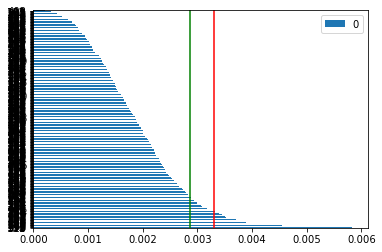

In [28]:
plt = pd.DataFrame(feature_imp).plot.barh()
#pandas version bellow 0.17.0
#df.plot(kind='barh')
plt.axvline(x=feature_imp.loc[512], c = "green", label = "random feature") #0.00044142161042745094
#plt.axvline(x=0.0043, c = "red")
plt.axvline(x=0.0033, c = "red")


plt.show()

In [29]:
sum(feature_imp > feature_imp.loc[512])
sum(feature_imp > 0.0033) #47 vs. 473

# 38

42

/Users/karinafeng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AttributeError: 'AxesSubplot' object has no attribute 'show'

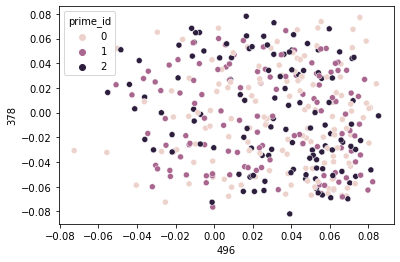

In [30]:
embed_df = pd.DataFrame(embeddings)
embed_df["s_id"] = pd.Series(long_df.story_id)
embed_df["prime_id"] = pd.Series(long_df.prime_id)

sns.scatterplot(496, 378, data=embed_df, hue = "prime_id")

plt.show()

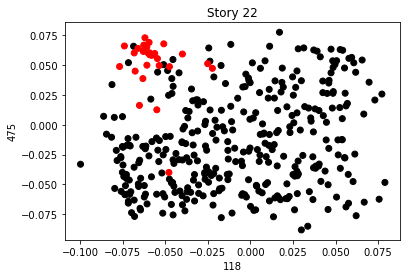

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

#colors = {'44':'red', '11':'black', '21':'black', '12':'black', '23':'black', '33':'black', '43':'black', 
#          '13':'black', '42':'black', '34':'black', '24':'black', '32':'black', '41':'black', '22':'black', 
#          '31':'black', '14':'black'}

colors = {44:'black', 11:'black', 21:'black', 12:'black', 23:'black', 33:'black', 43:'black', 
          13:'black', 42:'black', 34:'black', 24:'black', 32:'black', 41:'black', 22:'red', 
          31:'black', 14:'black'}



ax.scatter(embed_df[118], embed_df[475], c=embed_df['s_id'].map(colors))
plt.title("Story 22")
plt.xlabel("118")
plt.ylabel("475")
plt.show()

Text(0, 0.5, '475')

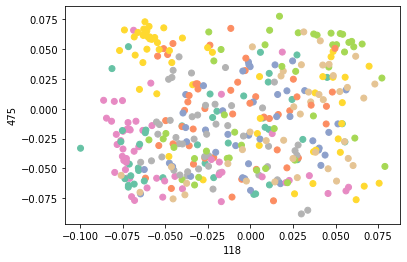

In [34]:
color_labels = embed_df['s_id'].unique()
rgb_values = sns.color_palette("Set2", 16)
color_map = dict(zip(color_labels, rgb_values))

plt.scatter(embed_df[118], embed_df[475], c=embed_df['s_id'].map(color_map))
plt.xlabel("118")
plt.ylabel("475")

In [35]:
imp_vars = list(pd.DataFrame(feature_imp[feature_imp > 0.0033]).index)

df_embed = pd.DataFrame(embeddings)
imp_data = df_embed[df_embed.columns.intersection(imp_vars)]

imp_embeds = np.array(imp_data)
imp_embeds.shape

(376, 42)

## Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(imp_embeds, p_labels, test_size = 0.3, random_state = 123)



In [37]:
clf_model = DecisionTreeClassifier(random_state=42) # criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5   
clf_model.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [38]:
y_predict = clf_model.predict(X_test)
accuracy_score(y_test,y_predict)
# 0.6371681415929203 when you use 38 embeddings from the tuned model


# 0.5309734513274337 when you use 47 embeddings for story
# 0.49557522123893805 when 473 embeddings for story

# 0.39823008849557523 when you use 19 embeddings for prime

0.39823008849557523

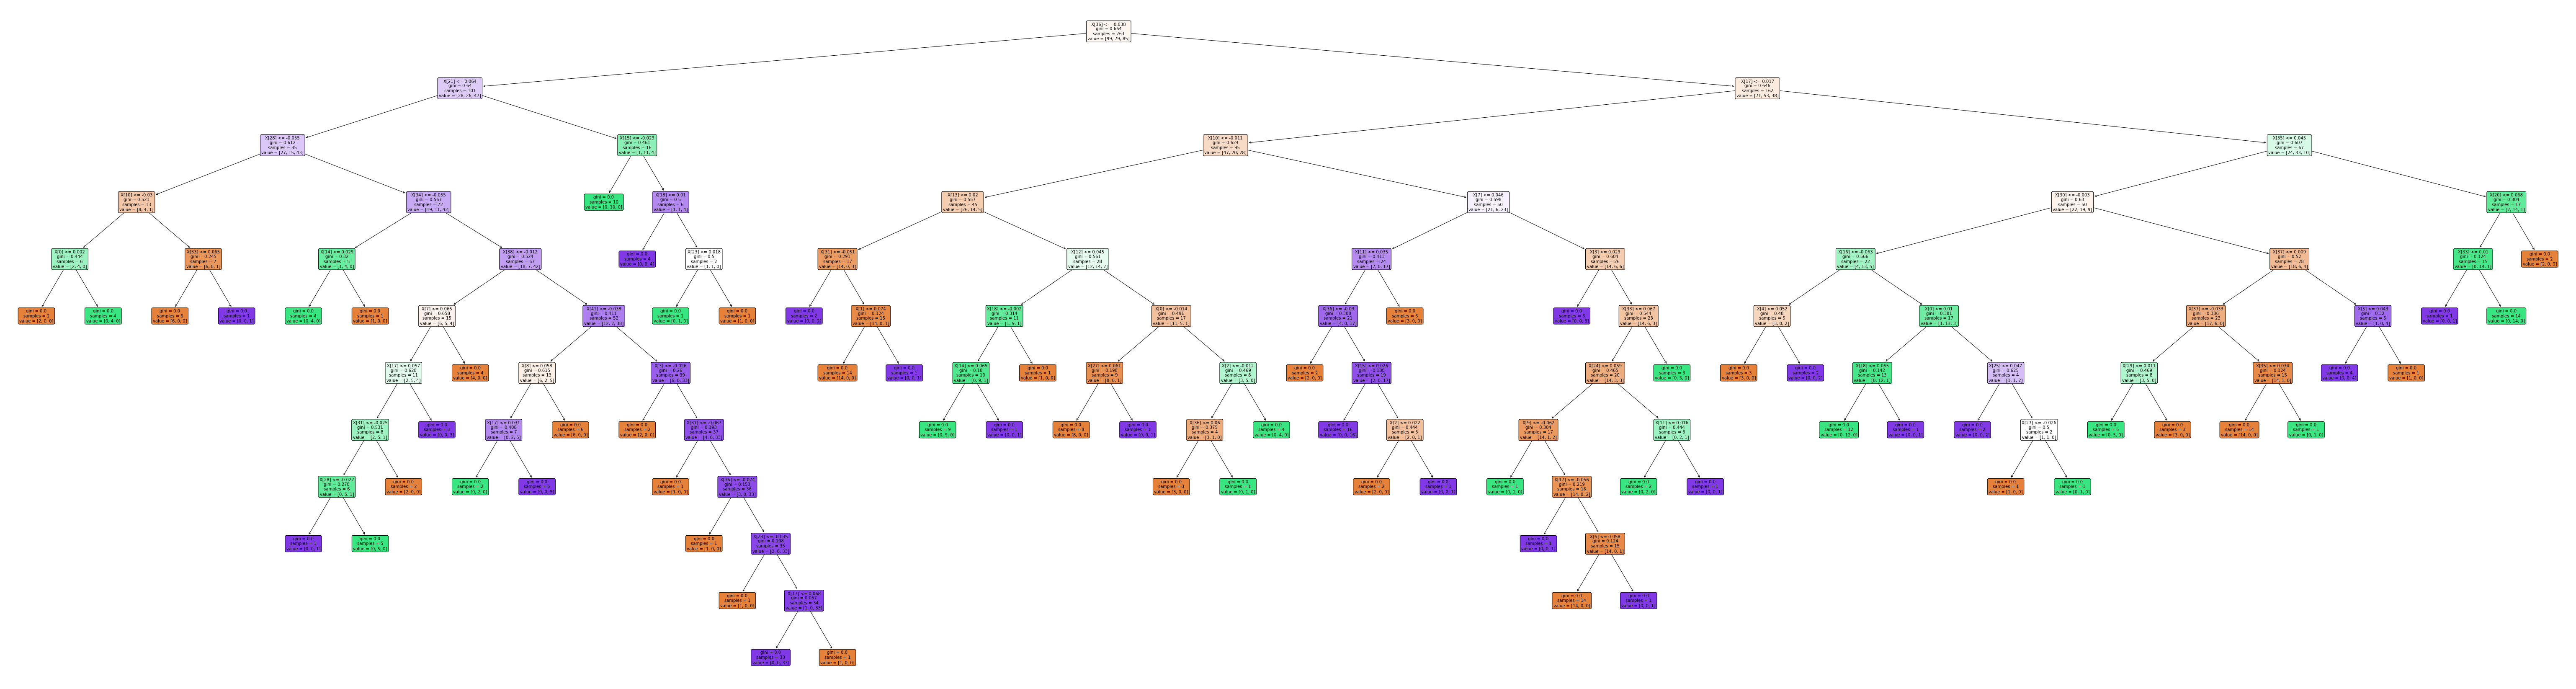

In [39]:
from sklearn import tree
plt.figure(figsize=(110, 30))  # set plot size (denoted in inches)
tree.plot_tree(clf_model, fontsize = 10, filled=True, rounded=True)
plt.show()

